## GDS

In [2]:
import json 
import pandas as pd
from neo4j import GraphDatabase
import seaborn as sns
sns.set()

### Connect

In [5]:
driver = GraphDatabase.driver(uri = "bolt://localhost:7687",\
                              auth = ("neo4j","12345678"))

In [6]:
driver.verify_connectivity()

### Link Prediction (Proteins to PTM_Types)

In [14]:
dfp = pd.read_csv("AAC interacting protein's PTM network.csv")
dfp.head(2)

,UID,name,modifiedResidue.position,ptmType
0,"""P62993""","""Growth factor receptor-bound protein 2""","[""50"", 32, ""1"", ""211"", ""6"", ""109""]","[""n6-acetyllysine"", ""S-succination"", ""S-sulfen..."
1,"""P05412""","""Transcription factor Jun""","[""286"", ""8"", ""271"", ""93"", ""249"", ""2"", ""89"", ""9...","[""phosphothreonine"", ""n6-acetyllysine"", ""phosp..."


In [15]:
dfp.columns

Index(['UID', 'name', 'modifiedResidue.position', ' ptmType'], dtype='object')

In [18]:
# seperate the each ptmType for each of the protein using explode method
dfp = dfp.explode(' ptmType')
dfp.head(2)

,UID,name,modifiedResidue.position,ptmType
0,"""P62993""","""Growth factor receptor-bound protein 2""","[""50"", 32, ""1"", ""211"", ""6"", ""109""]","[""n6-acetyllysine"", ""S-succination"", ""S-sulfen..."
1,"""P05412""","""Transcription factor Jun""","[""286"", ""8"", ""271"", ""93"", ""249"", ""2"", ""89"", ""9...","[""phosphothreonine"", ""n6-acetyllysine"", ""phosp..."


In [33]:
# create a new dataframe with only the columns UID and ptmType
dfp_selected = dfp[['UID',' ptmType']]

In [34]:
dfp_selected.head(2)

,UID,ptmType
0,"""P62993""","[""n6-acetyllysine"", ""S-succination"", ""S-sulfen..."
1,"""P05412""","[""phosphothreonine"", ""n6-acetyllysine"", ""phosp..."


In [35]:
import ast
dfp_selected['UID'] = dfp_selected['UID'].apply(lambda x: ast.literal_eval(x))
dfp_selected[' ptmType'] = dfp_selected[' ptmType'].apply(lambda x: ast.literal_eval(x))

/var/folders/c9/626zttsd7tg05l1sgcqp38200000gn/T/ipykernel_7062/3571810369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp_selected['UID'] = dfp_selected['UID'].apply(lambda x: ast.literal_eval(x))
/var/folders/c9/626zttsd7tg05l1sgcqp38200000gn/T/ipykernel_7062/3571810369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp_selected[' ptmType'] = dfp_selected[' ptmType'].apply(lambda x: ast.literal_eval(x))


In [36]:
# seperate each PTM type for each of the protein using explode method
dfp_selected = dfp_selected.explode(' ptmType')
dfp_selected.head(2)

,UID,ptmType
0,P62993,n6-acetyllysine
0,P62993,S-succination


In [55]:
aptm = ["n-acetylglycine",
"phosphoserine",
"n6,n6,n6-trimethyllysine",
"n6-succinyllysine",
"S-sulfenylation",
"S-nitrosylation",
"s-nitrosocysteine",
"n6-succinyllysine",
"n6-succinyllysine",
"n-acetylmethionine",
"n-acetylthreonine",
"phosphoserine",
"n6-malonyllysine",
"n6-succinyllysine",
"n6-methyllysine",
"n6,n6,n6-trimethyllysine",
"n6,n6-dimethyllysine",
"S-persulfidation",
"n6-malonyllysine",
"n6-malonyllysine",
"n6-acetyllysine",
"n6-succinyllysine",
"n6-succinyllysine",
"n6-malonyllysine",
"n6-methyllysine",
"n6-acetyllysine",
"S-persulfidation",
"S-palmitoylation",
"S-sulfenylation",
"n6-acetyllysine",
"n6-acetyllysine",
"S-carbonylation",
"S-sulfenylation",
"S-glutathionylation",
"S-nitrosylation",
"n6-acetyllysine",
"n6-succinyllysine",]

In [56]:
adp = ["P12235","P05141"]

In [58]:
P = list(dfp_selected['UID'].unique())+adp
PT= list(dfp_selected[' ptmType'].unique())+aptm
PT = list(set(PT))

In [59]:
res = []

for p in P:
    for pt in PT:
    
        query = "MATCH (p:Protein {UID: '" + p + "'}) \
        MATCH (ptm:PTM_Type {identifier: '" + pt + "'}) \
        RETURN gds.alpha.linkprediction.totalNeighbors(p, ptm, \
        {relationshipQuery: null})\
        AS Score, p.name AS Protein, ptm.identifier AS PTM_Type"

        with driver.session() as session:
            info = session.run(query)
            for item in info:
                res.append({"Protein":item.values()[1], 
                            "PTM_Type":item.values()[2],
                            "Score":item.values()[0]})

In [60]:
df_res = pd.DataFrame(res)
df_res = df_res.sort_values("Score", ascending = False)
df_res.head(5)

,Protein,PTM_Type,Score
12,Growth factor receptor-bound protein 2,phosphoserine,121606.0
480,ADP/ATP translocase 2,phosphoserine,121574.0
298,Nuclear factor NF-kappa-B p105 subunit,phosphoserine,121509.0
116,Serine/threonine-protein kinase PAK 1,phosphoserine,121488.0
38,Transcription factor Jun,phosphoserine,121488.0


In [61]:
df_pivot = df_res.pivot(index="Protein", columns="PTM_Type", values="Score")
df_pivot.head(15)

PTM_Type,(3s)-3-hydroxyasparagine,S-carbonylation,S-glutathionylation,S-nitrosylation,S-palmitoylation,S-persulfidation,S-succination,S-sulfenylation,S-sulfinylation,citrulline,...,"n6,n6,n6-trimethyllysine","n6,n6-dimethyllysine",n6-acetyllysine,n6-malonyllysine,n6-methyllysine,n6-succinyllysine,phosphoserine,phosphothreonine,phosphotyrosine,s-nitrosocysteine
Protein,,,,,,,,,,,,,,,,,,,,,
ADP/ATP translocase 1,124.0,584.0,5504.0,9562.0,4086.0,2087.0,1046.0,2208.0,503.0,540.0,...,1639.0,1094.0,23487.0,275.0,1830.0,7443.0,121462.0,26177.0,10231.0,646.0
ADP/ATP translocase 2,236.0,695.0,5615.0,9674.0,4197.0,2197.0,1158.0,2319.0,615.0,652.0,...,1751.0,1205.0,23594.0,383.0,1940.0,7554.0,121574.0,26289.0,10343.0,759.0
COP9 signalosome complex subunit 5,93.0,553.0,5473.0,9532.0,4055.0,2055.0,1015.0,2178.0,472.0,509.0,...,1609.0,1063.0,23456.0,244.0,1799.0,7415.0,121432.0,26146.0,10200.0,616.0
Cytochrome c oxidase subunit NDUFA4,97.0,556.0,5476.0,9535.0,4059.0,2060.0,1019.0,2181.0,476.0,513.0,...,1613.0,1067.0,23459.0,248.0,1803.0,7419.0,121435.0,26150.0,10204.0,620.0
Growth factor receptor-bound protein 2,267.0,727.0,5646.0,9705.0,4229.0,2230.0,1188.0,2351.0,646.0,683.0,...,1783.0,1237.0,23627.0,418.0,1973.0,7589.0,121606.0,26319.0,10374.0,790.0
Leucine-rich repeat serine/threonine-protein kinase 2,88.0,548.0,5468.0,9527.0,4050.0,2051.0,1010.0,2173.0,467.0,504.0,...,1604.0,1058.0,23451.0,239.0,1794.0,7410.0,121421.0,26141.0,10195.0,611.0
Mitogen-activated protein kinase 7,124.0,584.0,5504.0,9563.0,4086.0,2087.0,1046.0,2209.0,503.0,540.0,...,1640.0,1094.0,23487.0,275.0,1830.0,7446.0,121462.0,26176.0,10231.0,647.0
Mitogen-activated protein kinase kinase kinase 14,92.0,552.0,5472.0,9531.0,4054.0,2055.0,1014.0,2177.0,471.0,508.0,...,1608.0,1062.0,23455.0,243.0,1798.0,7414.0,121431.0,26144.0,10199.0,615.0
Nuclear factor NF-kappa-B p105 subunit,178.0,639.0,5559.0,9616.0,4141.0,2142.0,1101.0,2264.0,558.0,595.0,...,1695.0,1149.0,23539.0,330.0,1885.0,7501.0,121509.0,26231.0,10286.0,701.0


In [62]:
df_pivot.to_csv("result.csv")

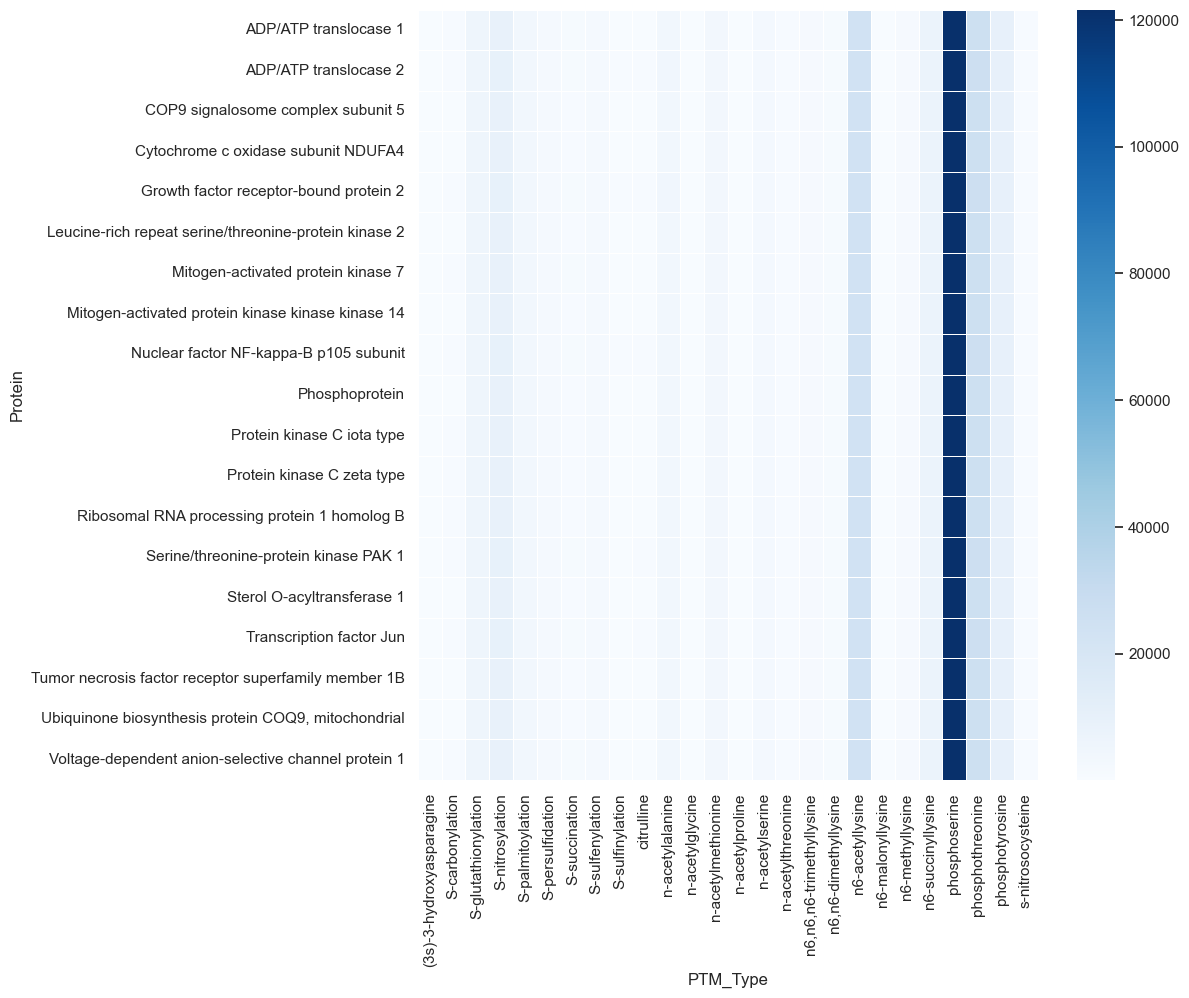

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize = [10,10])
sns.heatmap(df_pivot,cmap="Blues", annot=False, fmt=".2f", linewidth=.5)
plt.savefig("link-prediction-p2ptm.pdf")
plt.savefig("link-prediction-p2ptm.png")

### Link Prediction: Protein to PTM_Type (Specialized)